Bayesian Model


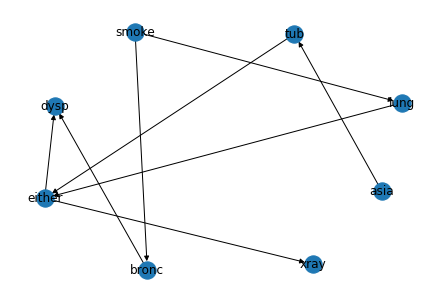

Moral Graph (Markov Model)


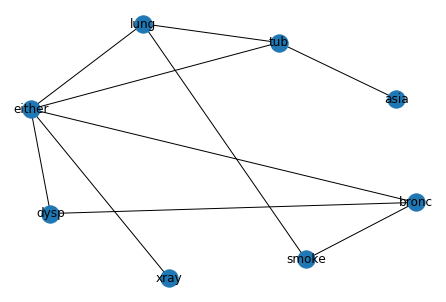

Triangulated Graph


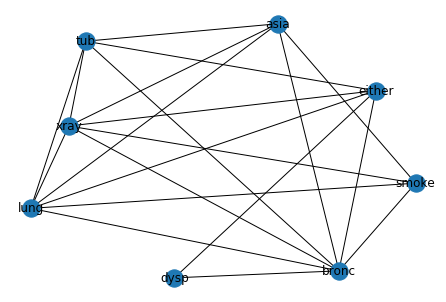

Junction Tree


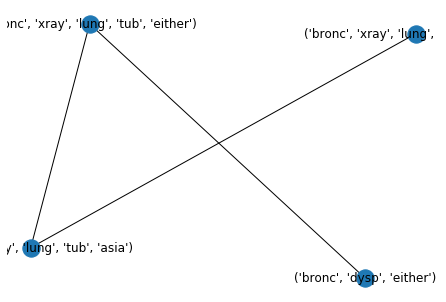

Labels:
('bronc', 'dysp', 'either')
('bronc', 'xray', 'lung', 'tub', 'either')
('bronc', 'xray', 'lung', 'tub', 'asia')
('bronc', 'xray', 'lung', 'smoke', 'asia')


In [1]:
# Lan Le - UB Person Number: 50322056
# CSE555 Problem Set 3: Exact Inference with Probabilistic Graphical Models




from pgmpy.models import BayesianModel
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import BeliefPropagation



# define Bayesian network structure
asia_model = BayesianModel([('asia', 'tub'),
                            ('tub', 'either'),
                            ('lung', 'either'),
                            ('either', 'dysp'),
                            ('either', 'xray'),
                            ('smoke', 'lung'),
                            ('smoke', 'bronc'),
                            ('bronc', 'dysp')])

print('Bayesian Model')
nx.draw(asia_model, with_labels=True)
plt.show()

# define individual CPDs (states: 0-yes, 1-no)
cpd_asia = TabularCPD(variable='asia', variable_card=2,
                      values=[[0.01], [0.99]])
cpd_smoke = TabularCPD(variable='smoke', variable_card=2,
                       values=[[0.5], [0.5]])
cpd_tub = TabularCPD(variable='tub', variable_card=2,
                        values=[[0.05, 0.01], [0.95, 0.99]],
                        evidence=['asia'], evidence_card=[2])
cpd_lung = TabularCPD(variable='lung', variable_card=2,
                      values=[[0.1, 0.01], [0.9, 0.99]],
                      evidence=['smoke'], evidence_card=[2])
cpd_bronc = TabularCPD(variable='bronc', variable_card=2,
                      values=[[0.6, 0.3], [0.4, 0.7]],
                      evidence=['smoke'], evidence_card=[2])
cpd_xray = TabularCPD(variable='xray', variable_card=2,
                      values=[[0.98, 0.05], [0.02, 0.95]],
                      evidence=['either'], evidence_card=[2])
cpd_either = TabularCPD(variable='either', variable_card=2,
                      values=[[1, 1, 1, 0], [0, 0, 0, 1]],
                      evidence=['lung', 'tub'], evidence_card=[2, 2])
cpd_dysp = TabularCPD(variable='dysp', variable_card=2,
                      values=[[0.9, 0.7, 0.8, 0.1], [0.1, 0.3, 0.2, 0.9]],
                      evidence=['bronc', 'either'], evidence_card=[2, 2])

# associate the CPDs with the network
asia_model.add_cpds(cpd_asia, cpd_smoke, cpd_tub, cpd_lung, cpd_bronc,
                   cpd_xray, cpd_either, cpd_dysp)

#asia_model.check_model()
#print(cpd_tub)

# convert Bayesian model to Markov model (moral graph)
moral_graph = asia_model.to_markov_model()
print('Moral Graph (Markov Model)')
nx.draw(moral_graph, with_labels=True)
plt.show()

# triangulate moral graph
tri_graph = moral_graph.triangulate()
print('Triangulated Graph')
nx.draw(tri_graph, with_labels=True)
plt.show()

# convert Markov model (moral graph) to junction tree
junc_tree = moral_graph.to_junction_tree()
print('Junction Tree')
nx.draw(junc_tree, with_labels=True)
plt.show()
print('Labels:')
for node in junc_tree.nodes():
    print(node)

The "running intersection property" is satisfied in the junction tree since if a variable is contained in two cliques then it would be contained in every clique on the path that connects them. <br>
For example, "bronc" exists in every path that connects (bronc, dysp, either) and (bronc, xray, lung, smoke, asia). 

In [2]:
# use message-passing algorithm to find the joint probability
bp = BeliefPropagation(asia_model)
bp.calibrate()
joint_prob = bp.query(variables=['tub', 'lung', 'bronc'], evidence={'asia': 0, 'xray': 0})
print(joint_prob)

Eliminating: smoke: 100%|██████████| 3/3 [00:00<00:00, 249.96it/s]

+----------+---------+--------+-----------------------+
| bronc    | lung    | tub    |   phi(bronc,lung,tub) |
+==========+=========+========+=======================+
| bronc(0) | lung(0) | tub(0) |                0.0000 |
+----------+---------+--------+-----------------------+
| bronc(0) | lung(0) | tub(1) |                0.0003 |
+----------+---------+--------+-----------------------+
| bronc(0) | lung(1) | tub(0) |                0.0002 |
+----------+---------+--------+-----------------------+
| bronc(0) | lung(1) | tub(1) |                0.0002 |
+----------+---------+--------+-----------------------+
| bronc(1) | lung(0) | tub(0) |                0.0000 |
+----------+---------+--------+-----------------------+
| bronc(1) | lung(0) | tub(1) |                0.0002 |
+----------+---------+--------+-----------------------+
| bronc(1) | lung(1) | tub(0) |                0.0003 |
+----------+---------+--------+-----------------------+
| bronc(1) | lung(1) | tub(1) |                0

The joint probability of "tub=yes, lung=yes, bronc=yes", given evidence that "asia=yes, xray=yes" is 0 (or very close to 0). <br>
The different terms on the right hand side of $p(V) = p(a)p(t | a)p(s)p(l | s)p(b | s)p(e | t, l)p(d | e, b)p(x | e)$ are distributed among the different juction tree clusters so that we can use these factors to compute the potentials of each cluster. It is important to note that the scope of a factor has to be a subset of the cluster that it belongs to. <br>
('bronc', 'dysp', 'either'): $p(d|e,b)$ <br>
('bronc', 'xray', 'lung', 'tub', 'either'): $p(x|e)$, $p(e|t,l)$ <br>
('bronc', 'xray', 'lung', 'tub', 'asia'): $p(t|a)$, $p(a)$ <br>
('bronc', 'xray', 'lung', 'smoke', 'asia'): $p(b|s)$, $p(l|s)$, $p(s)$<br>
<br>
These cluster potentials are then used to create message to pass between clusters in order to calculate cluster marginals. <br>
For this problem, we need to find the joint probability $p(t,l,b|a,x)$. To do so, we need to find $p(t,l,b,a,x)$ and $p(a,x)$, both of which can be found using message passing algorithm. In fact, using message passing algorithm, we should be able to compute marginal for any node and build up from there. <br>
E.g. The messages between clusters if we pick (b,x,l,t,a) to be the root: <br>
- $\delta_1 (b,e) = {\sum_{d} \Psi_1 (b,d,e)}$ from (b,d,e) to (b,x,l,t,e) <br>
- $\delta_2 (b,x,l,t) = {\sum_{e} (\Psi_2 (b,x,l,t,e) ({\sum_{d} \Psi_1 (b,d,e)}))}$ from (b,x,l,t,e) to (b,x,l,t,a) <br>
- $\delta_3 (b,x,l,a) = {\sum_{s} \Psi_3 (b,x,l,s,a)}$ from (b,x,l,s,a) to (b,x,l,t,a)